In [1]:
#from google.colab import files
#uploaded = files.upload()

In [2]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots
import re
import string

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

In [3]:
# create test and train sets
all_data = pd.read_json("train.json")
outcomes = all_data["requester_received_pizza"]
features = all_data.drop("requester_received_pizza", axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.1, random_state=6)

X_train.columns

Index(['giver_username_if_known',
       'number_of_downvotes_of_request_at_retrieval',
       'number_of_upvotes_of_request_at_retrieval', 'post_was_edited',
       'request_id', 'request_number_of_comments_at_retrieval', 'request_text',
       'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_account_age_in_days_at_retrieval',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_days_since_first_post_on_raop_at_retrieval',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_comments_in_raop_at_retrieval',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_at_retrieval',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_posts_on_raop_at_retrieval',
       'requester_number_of_subreddits_at_request',
  

In [4]:
# create a train/test set with only numeric fields
numeric_columns = ["number_of_downvotes_of_request_at_retrieval",
                   "number_of_upvotes_of_request_at_retrieval",
                   "post_was_edited",
                   "request_number_of_comments_at_retrieval",
                   "requester_account_age_in_days_at_request",
                   "requester_days_since_first_post_on_raop_at_request",
                   "requester_number_of_comments_at_request",
                   "requester_number_of_comments_in_raop_at_request",
                   "requester_number_of_posts_at_request",
                   "requester_number_of_subreddits_at_request",
                   "requester_upvotes_minus_downvotes_at_request",
                   "requester_upvotes_plus_downvotes_at_request"
]

In [5]:
X_train_numeric_only = X_train[numeric_columns]
X_test_numeric_only = X_test[numeric_columns]

In [6]:
number_of_features = X_train_numeric_only.shape[1]
model = keras.Sequential()
model.add(keras.layers.Dense(1,activation = 'sigmoid',input_dim = number_of_features))
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(x = X_train_numeric_only, y = y_train, epochs=10, validation_split=0.1)

Epoch 1/10
103/103 [==============================] - 1s 6ms/step - loss: 9711582.0000 - val_loss: 7977361.5000
Epoch 2/10
103/103 [==============================] - 1s 5ms/step - loss: 7627311.5000 - val_loss: 6098583.0000
Epoch 3/10
103/103 [==============================] - 1s 5ms/step - loss: 5583573.0000 - val_loss: 4206001.0000
Epoch 4/10
103/103 [==============================] - 1s 5ms/step - loss: 3517944.5000 - val_loss: 2325133.2500
Epoch 5/10
103/103 [==============================] - 1s 5ms/step - loss: 1437303.5000 - val_loss: 343907.3125
Epoch 6/10
103/103 [==============================] - 1s 5ms/step - loss: 61286.9570 - val_loss: 7313.1553
Epoch 7/10
103/103 [==============================] - 1s 5ms/step - loss: 12866.1016 - val_loss: 11791.9756
Epoch 8/10
103/103 [==============================] - 1s 5ms/step - loss: 10694.0225 - val_loss: 6157.2749
Epoch 9/10
103/103 [==============================] - 1s 5ms/step - loss: 15329.7383 - val_loss: 10348.3252
Epoch 10/10

In [7]:
y_train_pred_raw = model.predict(X_train_numeric_only)
y_train_pred = y_train_pred_raw > 0.5
y_test_pred_raw = model.predict(X_test_numeric_only)
y_test_pred = y_test_pred_raw > 0.5

13/13 [==============================] - 0s 1ms/step


In [8]:
y_test

2540     True
159     False
279     False
1563    False
1532    False
        ...  
1329    False
3780     True
1475    False
2534     True
1579    False
Name: requester_received_pizza, Length: 404, dtype: bool

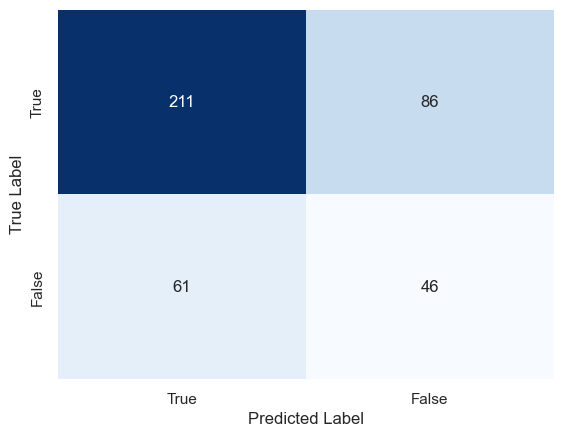

In [9]:
confusion_matrix = tf.math.confusion_matrix(y_test, y_test_pred)
label_names = [True, False]
# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [10]:
print("Train Accuracy:")
train_matches = sum(y_train.values == y_train_pred.flatten())
train_accuracy = train_matches / len(y_train.values)
print(round(train_accuracy, 4))
print("Test Accuracy:")
test_matches = sum(y_test.values == y_test_pred.flatten())
test_accuracy = test_matches / len(y_test.values)
print(round(test_accuracy, 4))

Train Accuracy:
0.6573
Test Accuracy:
0.6361


In [11]:
# Now lets add embeddings
def build_embeddings_model(average_over_positions=False,
                           vocab_size=1000,
                           sequence_length=20,
                           embedding_dim=2):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

    # Add a 1D Convolutional layer to capture local patterns in the text
  model.add(tf.keras.layers.Conv1D(
      filters=16,        # Number of filters (output channels)
      strides=3,         # Stride size for the convolution operation
      padding='same',    # Padding to ensure the output has the same length as the input
      kernel_size=16,    # Length of the convolutional kernel (window size)
      activation='relu'
  ))

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model

def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [12]:
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = oov_id
  return reduced_sequences

def preprocess_text(text):
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))

  # Convert to lowercase
  text = text.lower()

  # Tokenize the text into individual words
  words = re.findall(r'\b\w+\b', text)

  return words

In [13]:
# text only
all_data_text = all_data['request_text_edit_aware'].apply(preprocess_text)
all_data_text.shape

(4040,)

In [14]:
# Create a vocabulary of all the unique words in the text data
vocab = set()
for text in all_data_text:
    vocab.update(text)

# Create a word-to-index mapping
word_to_index = {}
for i, word in enumerate(vocab):
    word_to_index[word] = i

In [15]:
all_data_text_vectorized = all_data_text.apply(lambda x: [word_to_index[word] for word in x])
all_data_result = all_data['requester_received_pizza'].astype(int)
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(all_data_text_vectorized, all_data_result, test_size=0.1, random_state=6)

In [16]:
y_train_text

1487    0
705     1
2845    0
3894    0
3110    0
       ..
618     0
2004    0
227     0
2761    0
2954    0
Name: requester_received_pizza, Length: 3636, dtype: int64

In [17]:
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))

X_train_text_padded = pad_data(X_train_text, max_length=500)
# print(X_train_text.shape)
# print(X_train_text_padded.shape)
# print(len(X_train_text[1]))
# print(len(X_train_text_padded[1]))
# print(type(X_train_text[1][0]))
# print(X_train_text[1])
# print(X_train_text_padded[1])

Epoch 1/15
52/52 [==============================] - 10s 166ms/step - loss: 0.6569 - accuracy: 0.7335 - val_loss: 0.5949 - val_accuracy: 0.7720
Epoch 2/15
52/52 [==============================] - 8s 160ms/step - loss: 0.5664 - accuracy: 0.7543 - val_loss: 0.5366 - val_accuracy: 0.7720
Epoch 3/15
52/52 [==============================] - 8s 154ms/step - loss: 0.5551 - accuracy: 0.7543 - val_loss: 0.5369 - val_accuracy: 0.7720
Epoch 4/15
52/52 [==============================] - 7s 144ms/step - loss: 0.5536 - accuracy: 0.7543 - val_loss: 0.5365 - val_accuracy: 0.7720
Epoch 5/15
52/52 [==============================] - 7s 143ms/step - loss: 0.5531 - accuracy: 0.7543 - val_loss: 0.5365 - val_accuracy: 0.7720
Epoch 6/15
52/52 [==============================] - 7s 143ms/step - loss: 0.5516 - accuracy: 0.7543 - val_loss: 0.5380 - val_accuracy: 0.7720
Epoch 7/15
52/52 [==============================] - 8s 147ms/step - loss: 0.5508 - accuracy: 0.7543 - val_loss: 0.5377 - val_accuracy: 0.7665
Epoch

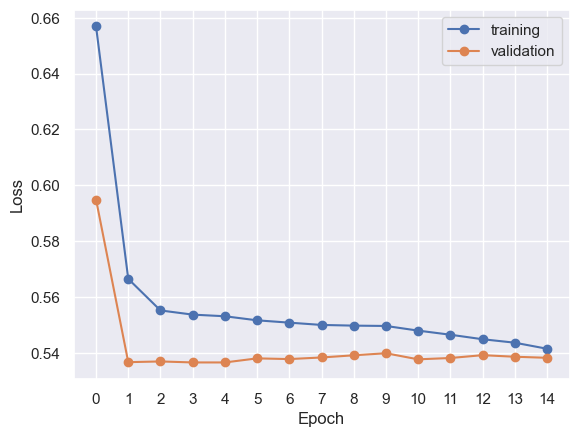

In [18]:
# text only
X_train_text_reduced = limit_vocab(X_train_text_padded, max_token_id=3000)
embeddings_model = build_embeddings_model(average_over_positions=True,
                               vocab_size=3000,
                               sequence_length=500,
                               embedding_dim=2)
history = embeddings_model.fit(
  x = X_train_text_reduced,  # our sparse padded training data
  y = y_train_text,          # corresponding binary labels
  epochs=15,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

history = pd.DataFrame(history.history)
plot_history(history)

In [19]:
print("Train Acc:", 0.7543)
print("Validation Acc:", 0.7720)

Train Acc: 0.7543
Validation Acc: 0.772


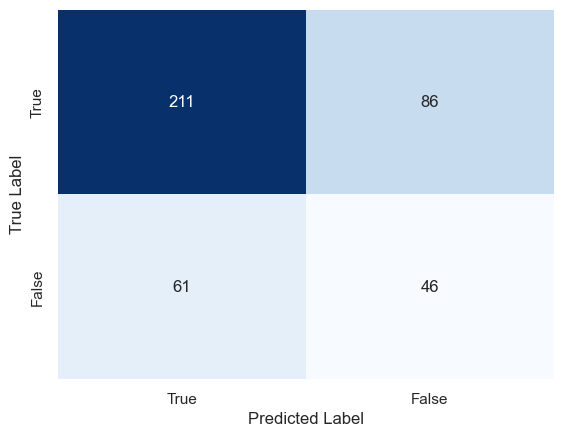

In [20]:
confusion_matrix = tf.math.confusion_matrix(y_test, y_test_pred)
label_names = [True, False]
# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()